In [1]:
import matplotlib.pyplot as plt
import time
from gengraph import EpsimGraph
from epsim import Epsim

In [2]:
# Testrun

starttime = time.time()
epsim_graph = EpsimGraph(k=100000, office_sigma=0.25, split_classes=False)
sim = Epsim()
sim.init_from_dicts(epsim_graph.family_nbrs, epsim_graph.school_nbrs, epsim_graph.office_nbrs)
sim.run_sim(sim_iters=200, family_spread_prob=0.3, school_office_spread_prob=0.16, immunize_prob=0.25,\
           testing_prob=0.5, print_progress=True, export_csv=False)
print('runtime: {}s'.format(time.time() - starttime))

creating graph with k=100000, office_sigma=0.25
randomly cluster children and parent nodes, such that there are child-parent pairs
parents: 1/2 no change, 1/4 merge 2 nodes, 1/8 merge 3 nodes, ...
parents: duplicate every node
children: k/l^2 many l*l grids, place l^2 nodes randomly on grid, cluster 8 neighbourhood, with l=5
parents: cluster 1-office_sigma no change, office_sigma*1/2 cluster 2 nodes, office_sigma*1/4 cluster 3 nodes, office_sigma*1/8 cluster 4 nodes, office_sigma*1/8 cluster 5 nodes
starting simulation with n=238640, num_start_nodes=24, sim_iters=200
family_spread_prob=0.3, school_office_spread_prob=0.16, immunize_prob=0.25, testing_prob=0.5
0: [238616, 24, 0, 0, 0, 0]
1: [238616, 0, 24, 0, 0, 0]
2: [238578, 28, 0, 24, 0, 10]
3: [238543, 53, 0, 0, 24, 20]
4: [238543, 25, 28, 0, 0, 44]
5: [238524, 19, 25, 28, 0, 44]
6: [238512, 31, 0, 25, 28, 44]
7: [238487, 20, 19, 0, 14, 100]
8: [238466, 27, 10, 19, 0, 118]
9: [238450, 27, 10, 10, 19, 124]
10: [238426, 25, 17, 10, 10,

In [2]:
# Run with different parameters

sim_iters = 300
k = 100000
office_sigmas = [0.25, 0.33]
family_spread_prob = 0.3
school_office_spread_probs = [0.12, 0.14, 0.16]
immunize_probs = [0.25, 0.33]
testing_probs = [0.5, 0.75, 0.95]

results = {}
for office_sigma in office_sigmas:
    results[office_sigma] = {}
    for immunize_prob in immunize_probs:
        results[office_sigma][immunize_prob] = {}
        for testing_prob in testing_probs:
            results[office_sigma][immunize_prob][testing_prob] = {}
            for school_office_spread_prob in school_office_spread_probs:
                results[office_sigma][immunize_prob][testing_prob][school_office_spread_prob] = None

starttime = time.time()
for office_sigma in office_sigmas:
    epsim_graph = EpsimGraph(k, office_sigma, split_classes=False)
    sim = Epsim()
    sim.init_from_dicts(epsim_graph.family_nbrs, epsim_graph.school_nbrs, epsim_graph.office_nbrs)
    for immunize_prob in immunize_probs:
        for testing_prob in testing_probs:
            for school_office_spread_prob in school_office_spread_probs:
                x_rounds, y_num_infected = sim.run_sim(sim_iters, family_spread_prob, school_office_spread_prob, immunize_prob, testing_prob)
                results[office_sigma][immunize_prob][testing_prob][school_office_spread_prob] = (x_rounds, y_num_infected)
print('runtime: {}s'.format(time.time() - starttime))

creating graph with k=100000, office_sigma=0.25
randomly cluster children and parent nodes, such that there are child-parent pairs
parents: 1/2 no change, 1/4 merge 2 nodes, 1/8 merge 3 nodes, ...
parents: duplicate every node
children: k/l^2 many l*l grids, place l^2 nodes randomly on grid, cluster 8 neighbourhood, with l=5
parents: cluster 1-office_sigma no change, office_sigma*1/2 cluster 2 nodes, office_sigma*1/4 cluster 3 nodes, office_sigma*1/8 cluster 4 nodes, office_sigma*1/8 cluster 5 nodes
starting simulation with n=238640, num_start_nodes=24, sim_iters=300
family_spread_prob=0.3, school_office_spread_prob=0.12, immunize_prob=0.25, testing_prob=0.5
infected nodes: 415

starting simulation with n=238640, num_start_nodes=24, sim_iters=300
family_spread_prob=0.3, school_office_spread_prob=0.14, immunize_prob=0.25, testing_prob=0.5
infected nodes: 40660

starting simulation with n=238640, num_start_nodes=24, sim_iters=300
family_spread_prob=0.3, school_office_spread_prob=0.16, im

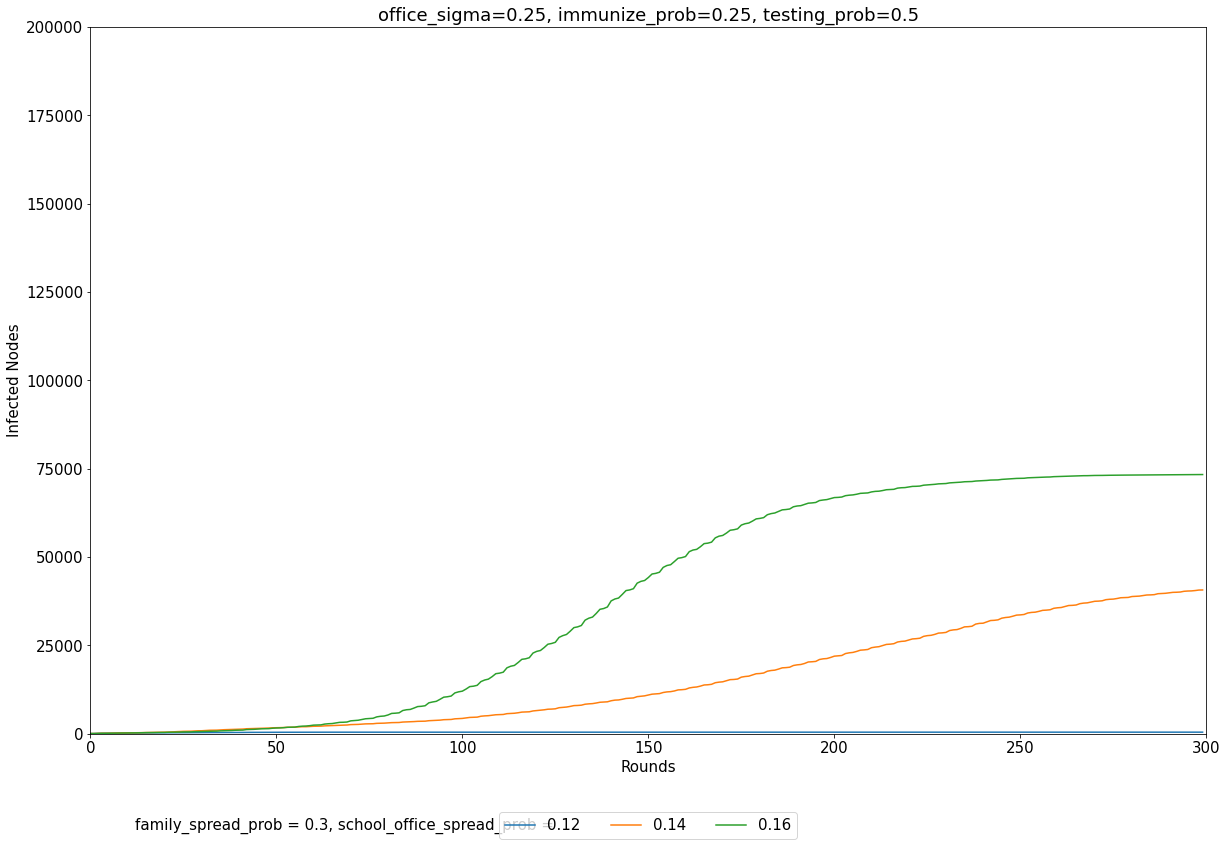

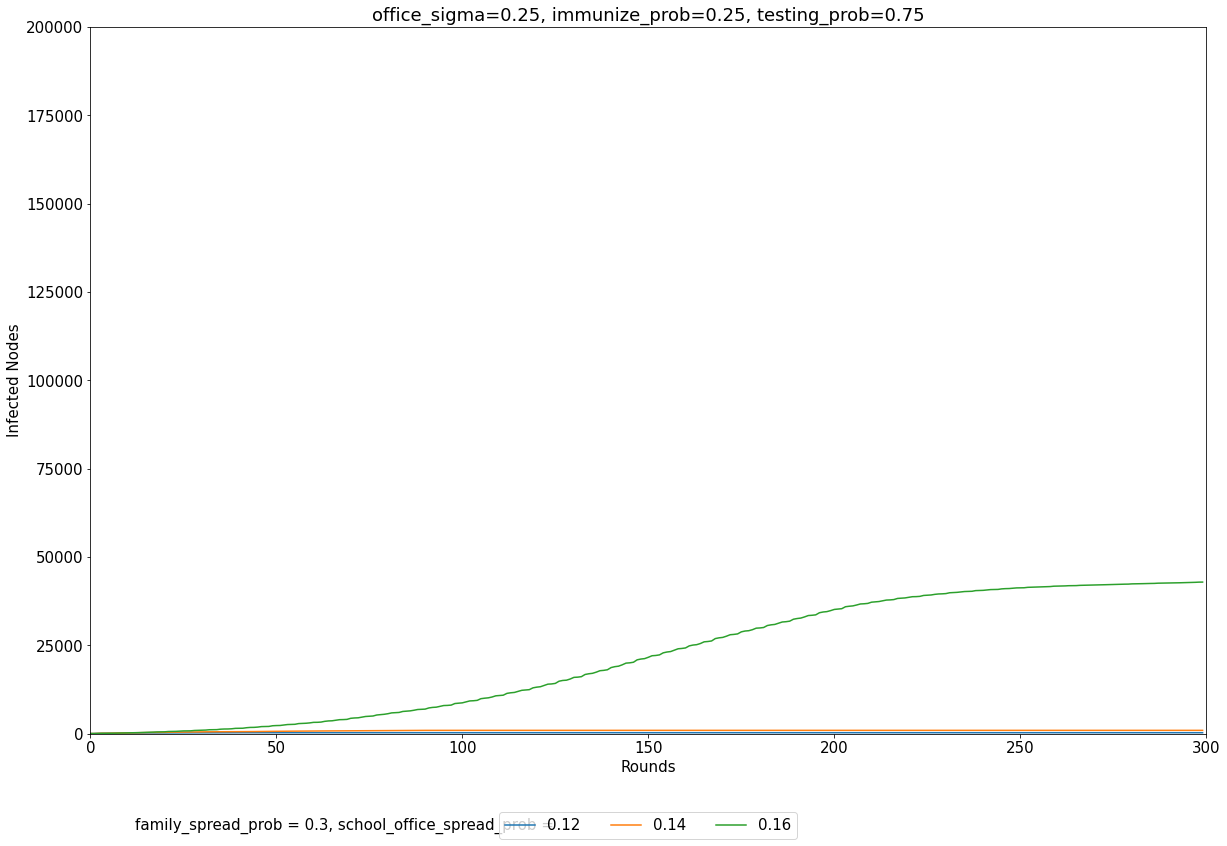

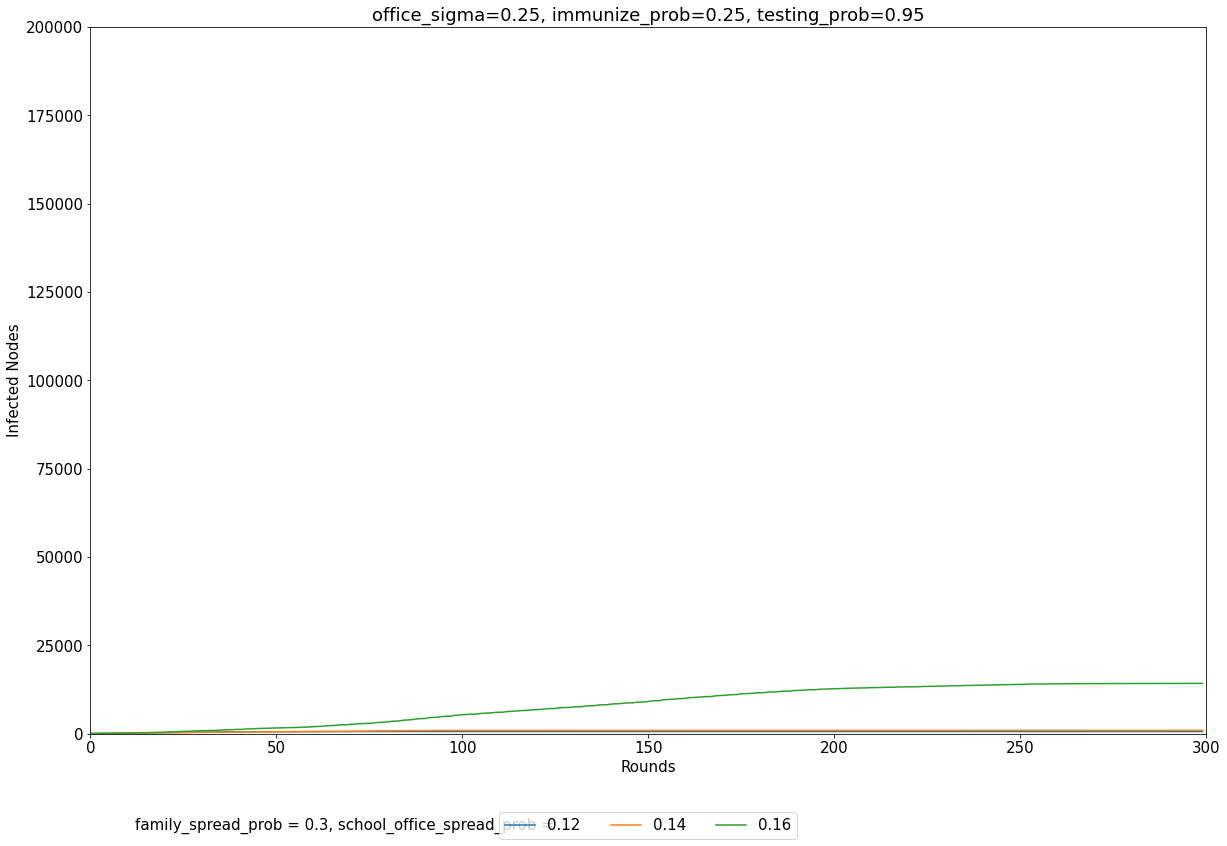

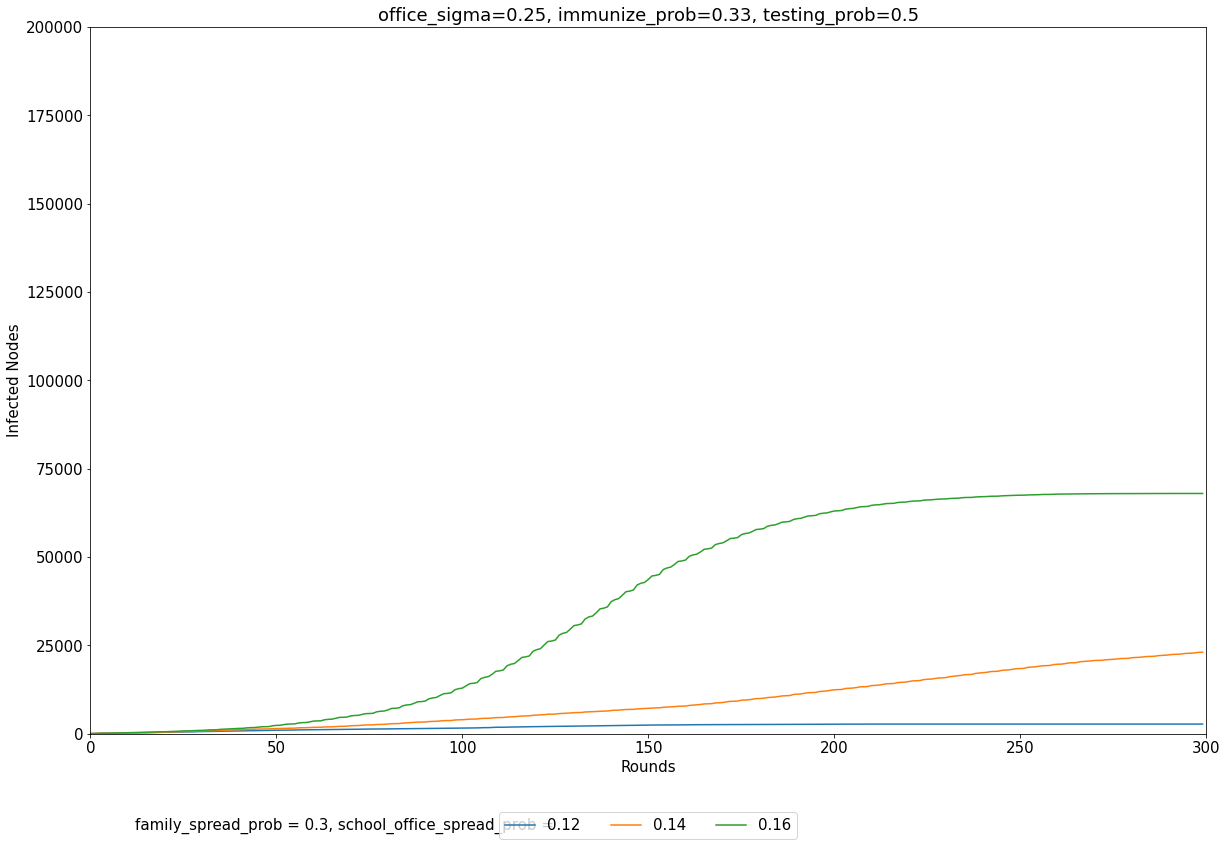

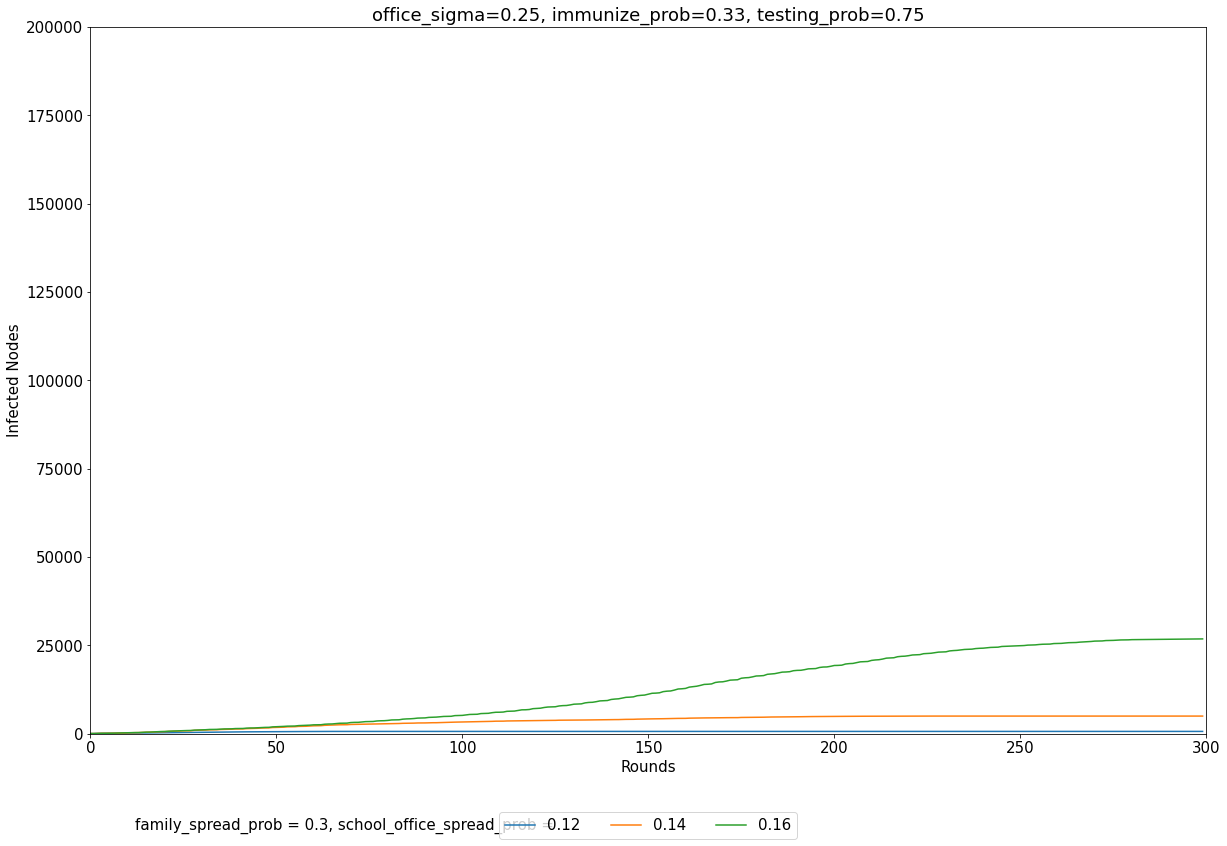

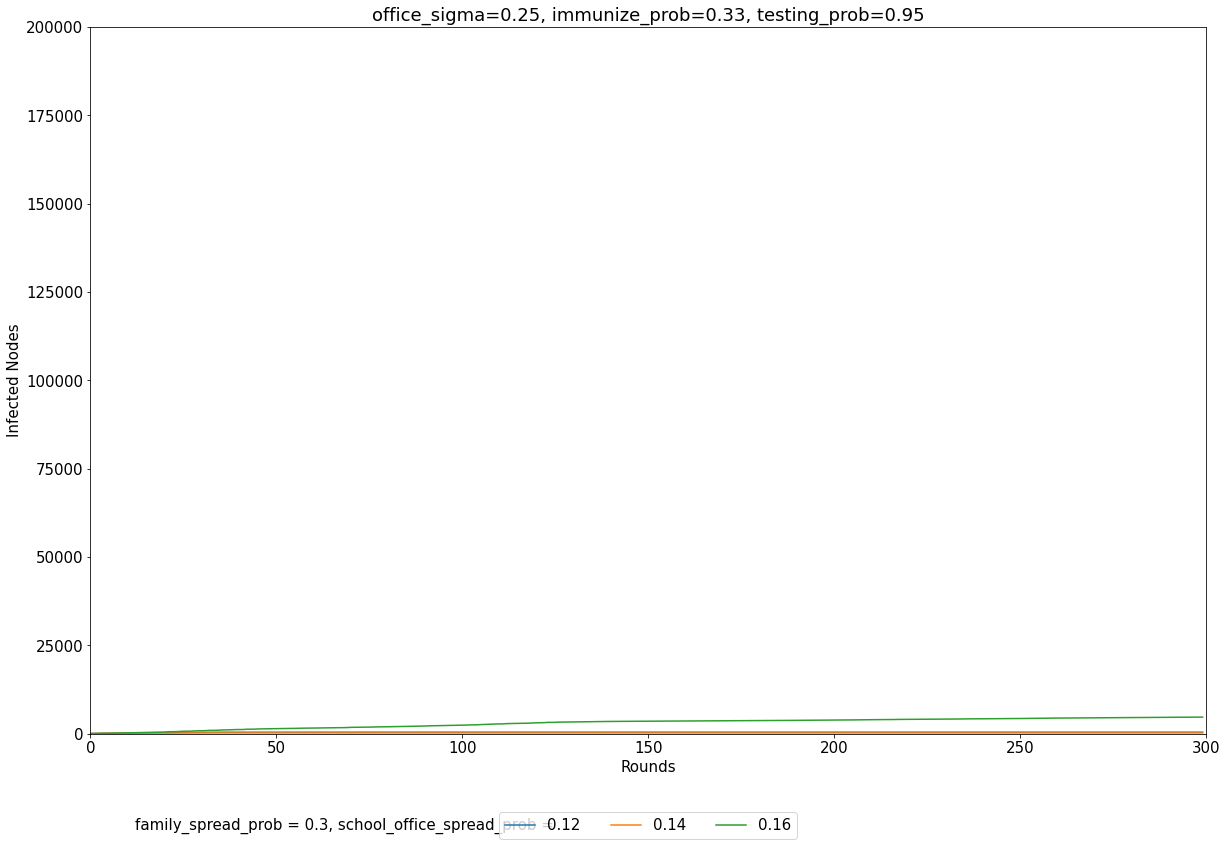

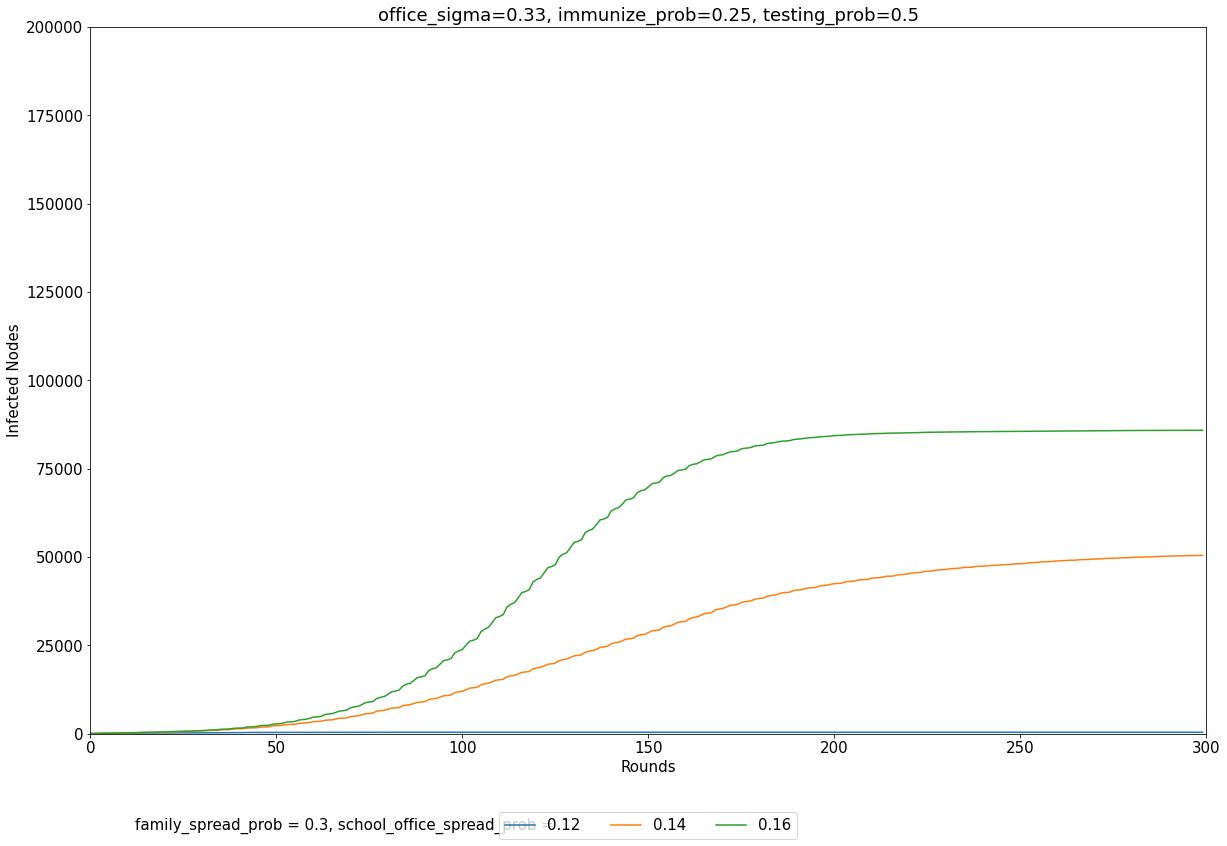

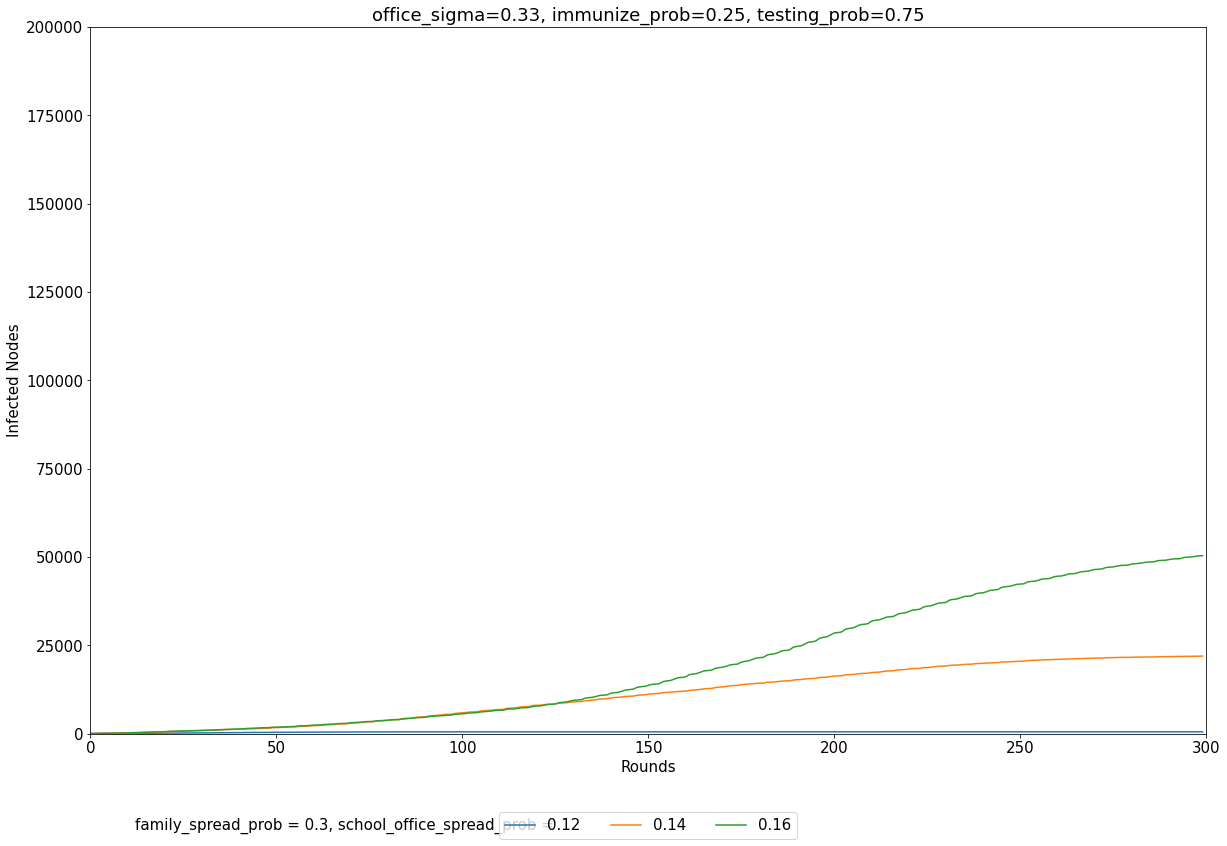

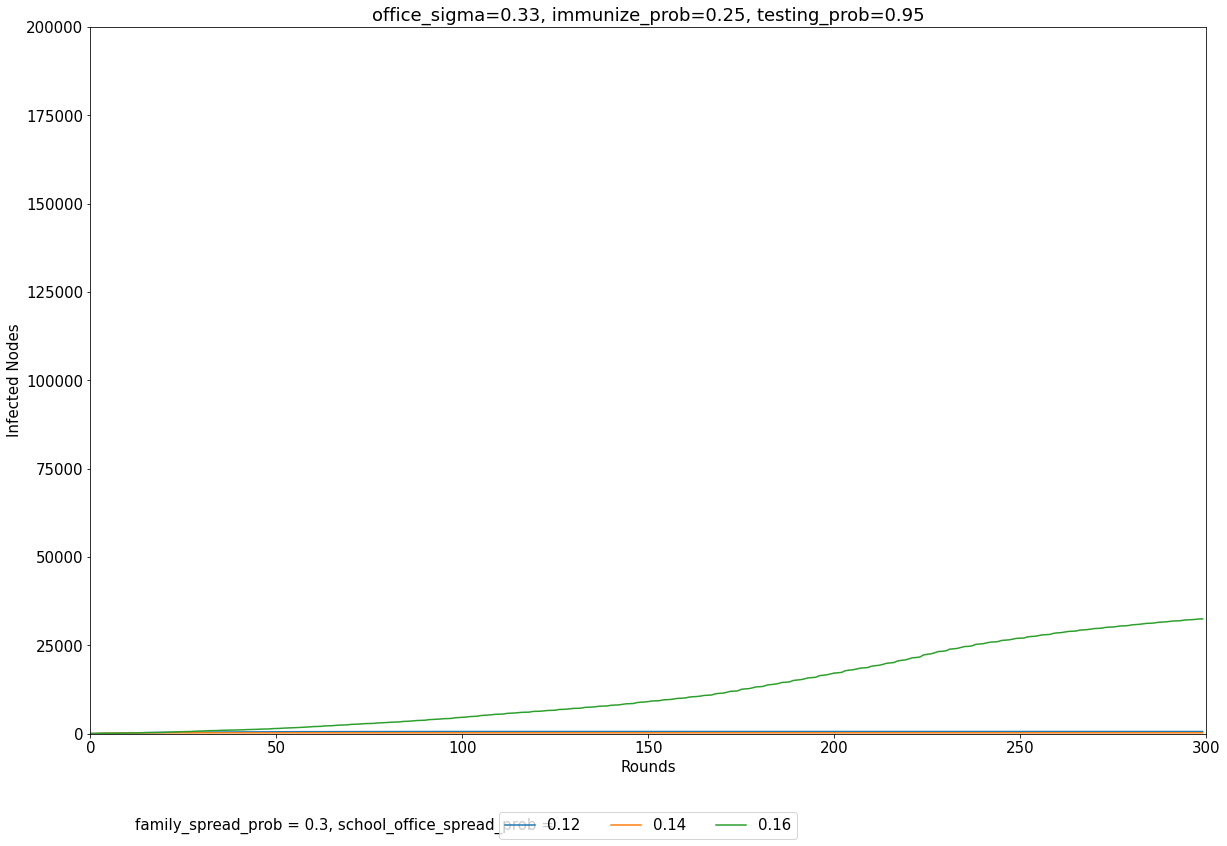

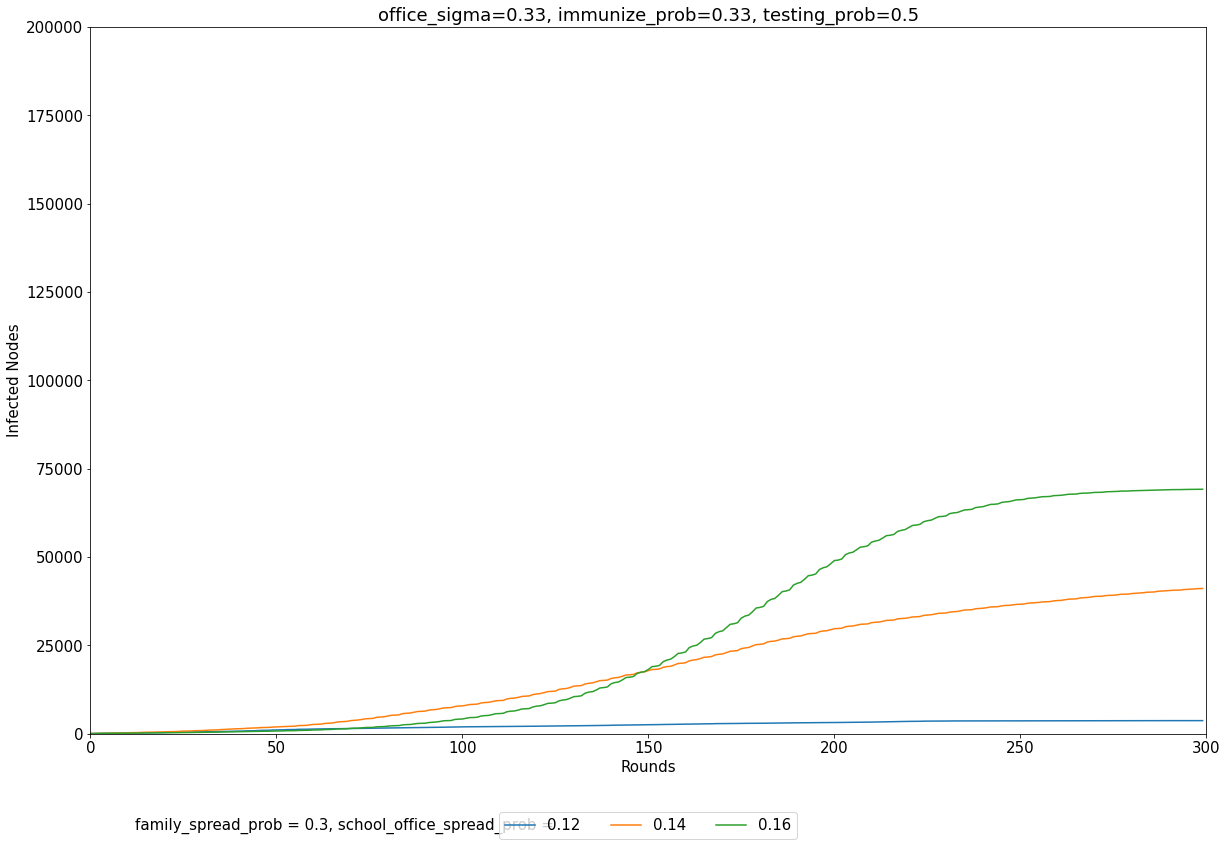

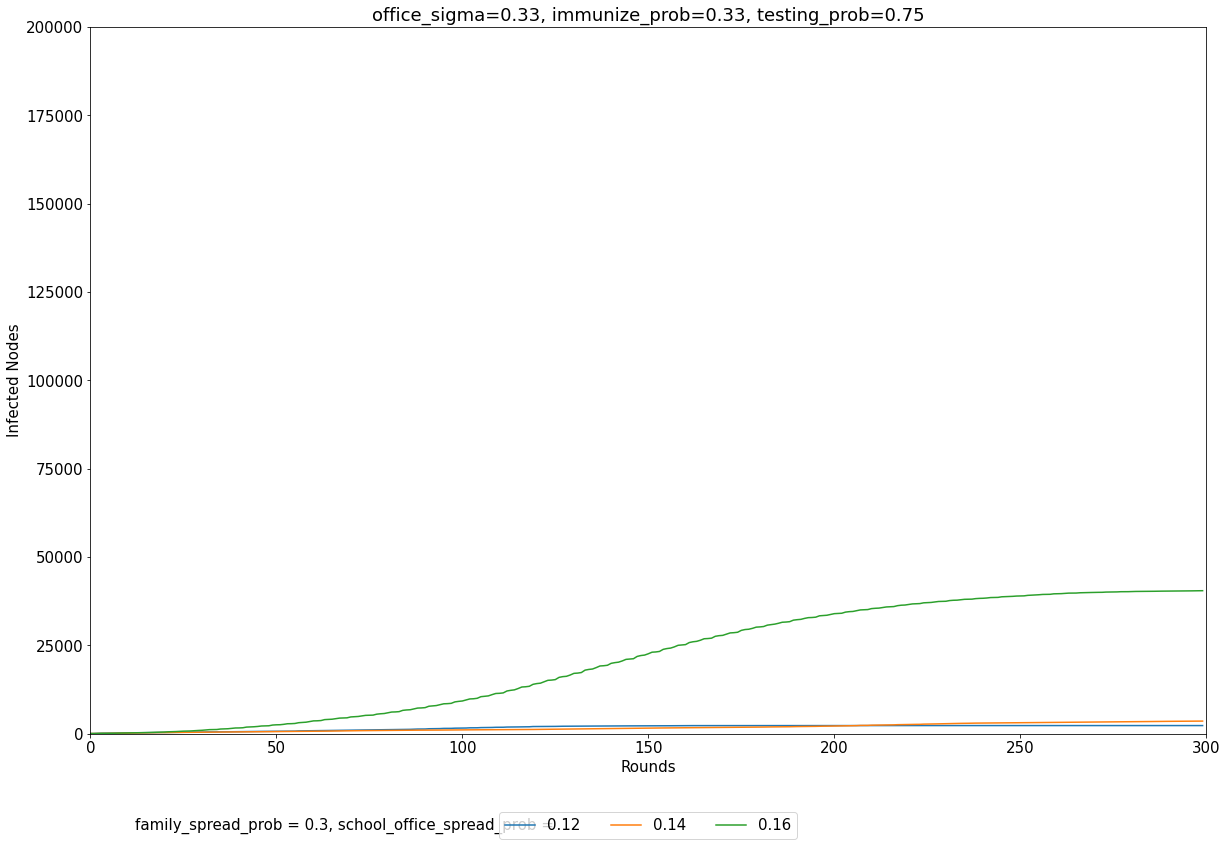

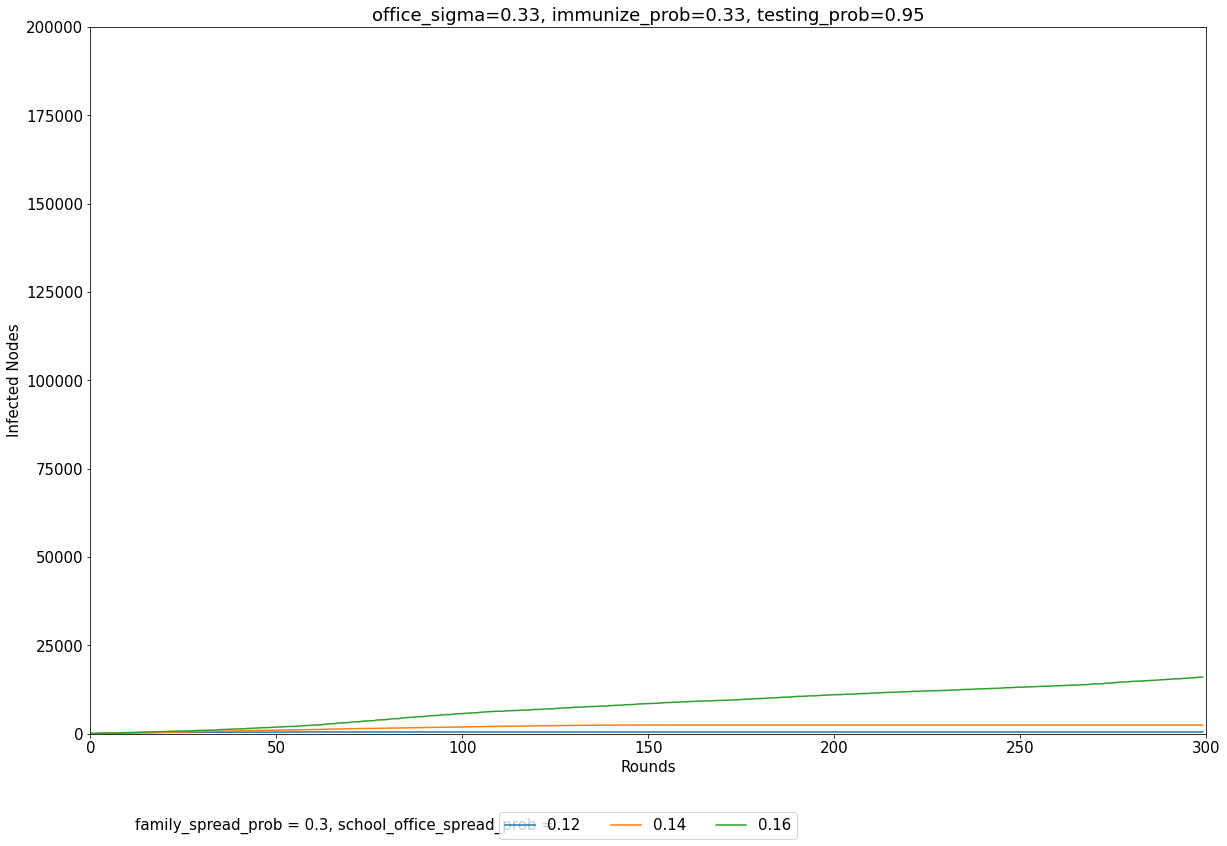

In [3]:
plt.rcParams.update({'font.size': 15})

for office_sigma in office_sigmas:
    for immunize_prob in immunize_probs:
        for testing_prob in testing_probs:
            fig, axs = plt.subplots(figsize=(20,13))
            axs.set_ylim(top=200000)
            axs.set_xlim(0, 300)
            for school_office_spread_prob in school_office_spread_probs:
                axs.plot(results[office_sigma][immunize_prob][testing_prob][school_office_spread_prob][0],\
                        results[office_sigma][immunize_prob][testing_prob][school_office_spread_prob][1],\
                        label=school_office_spread_prob)
            axs.set_title('office_sigma={}, immunize_prob={}, testing_prob={}'.format(office_sigma, immunize_prob, testing_prob))
            axs.set_xlabel('Rounds')
            axs.set_ylabel('Infected Nodes')
            axs.text(0.04, -0.136, 'family_spread_prob = {}, school_office_spread_prob ='.format(family_spread_prob), transform=axs.transAxes)
            axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)